# Fine Tuning Apple's FastViT for iOS Hand Gesture Recognition

In 2024, Apple researchers introduced FastViT, a neural network for computer vision intended to run on iOS devices.

In [5]:
import timm
import torch

In [4]:
from pprint import pprint
model_names = timm.list_models('*mobilenetv4*')
pprint(model_names)

['mobilenetv4_conv_aa_medium',
 'mobilenetv4_conv_blur_medium',
 'mobilenetv4_conv_large',
 'mobilenetv4_conv_medium',
 'mobilenetv4_conv_small',
 'mobilenetv4_hybrid_large',
 'mobilenetv4_hybrid_large_075',
 'mobilenetv4_hybrid_medium',
 'mobilenetv4_hybrid_medium_075']


In [8]:
model = timm.create_model('mobilenetv4_conv_medium', pretrained=True) # num_classes=NUM_FINETUNE_CLASSES
model.eval()

MobileNetV3(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): ReLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(32, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNormAct2d(
          128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): ReLU(inplace=True)
        )
        (aa): Identity()
        (se): Identity()
        (conv_pwl): Conv2d(128, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): Identity()
        )
        (drop_path): Identity()
      )
    )
    (1): Sequential(
      (0): Uni

In [ ]:
# Input an image to eval in the model

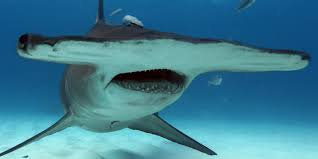

In [21]:
import requests
from PIL import Image
from io import BytesIO
url = 'https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRSZAWEusQ2tXgK6LywAnwiTBP5qnuvL8hZYA&s'
image = Image.open(requests.get(url, stream=True).raw)
image

In [22]:
model = timm.create_model('mobilenetv4_conv_medium', pretrained=True).eval()
transform = timm.data.create_transform(
    **timm.data.resolve_data_config(model.pretrained_cfg)
)

In [23]:
image_tensor = transform(image)
image_tensor.shape

torch.Size([3, 256, 256])

In [24]:
output = model(image_tensor.unsqueeze(0))
output.shape

torch.Size([1, 1000])

In [25]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)
probabilities.shape

torch.Size([1000])

In [26]:
values, indices = torch.topk(probabilities, 5)
indices

tensor([  4,   3,   2, 148, 173])

In [27]:
IMAGENET_1k_URL = 'https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt'
IMAGENET_1k_LABELS = requests.get(IMAGENET_1k_URL).text.strip().split('\n')
[{'label': IMAGENET_1k_LABELS[idx], 'value': val.item()} for val, idx in zip(values, indices)]

[{'label': 'hammerhead, hammerhead_shark', 'value': 0.46693283319473267},
 {'label': 'tiger_shark, Galeocerdo_cuvieri', 'value': 0.3481285870075226},
 {'label': 'great_white_shark, white_shark, man-eater, man-eating_shark, Carcharodon_carcharias',
  'value': 0.011041748337447643},
 {'label': 'killer_whale, killer, orca, grampus, sea_wolf, Orcinus_orca',
  'value': 0.0015154116554185748},
 {'label': 'Ibizan_hound, Ibizan_Podenco', 'value': 0.0011501640547066927}]